In [8]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from spire.doc import *
from spire.doc.common import *
from IPython.display import Image
from PIL import Image as PILImage
from typing import Counter

In [9]:
from FuncionesMineria import(
    analizar_variables_categoricas,
    cuentaDistintos, 
    frec_variables_num, 
    atipicosAmissing, 
    patron_perdidos,
    ImputacionCuant,
    ImputacionCuali,
    Vcramer,
    hist_targetbinaria,
    lm_stepwise,
    lm_backward,
    lm_forward,
    Rsq,
    crear_data_modelo,
    validacion_cruzada_lm
)

<h2> 2 - Preparacion de Datos </h2>

<h3>Extraccion de datos</h3>

In [10]:
datos = pd.read_excel("../Statement/DatosEleccionesEspaña.xlsx")

<h3>Asignar tipo de datos correctos</h3>

In [11]:
# Asignar tipo de datos correctos

colsFromFloatToInt = ["totalEmpresas", "Industria", "Construccion", "ComercTTEHosteleria", "Servicios", "inmuebles", "Pob2010", "PersonasInmueble"]
colsFromIntToBool = ["Izquierda", "Derecha", "AbstencionAlta"]

for c in colsFromFloatToInt:
    datos[c] = datos[c].fillna(-1)
    datos[c] = datos[c].astype(int)

for c in colsFromFloatToInt:
    datos[c] = datos[c].replace(-1, np.nan)

for c in colsFromIntToBool:
    datos[c] = datos[c].astype(bool)

<h3>3 - Analisis Descriptivo </h3>

In [12]:
print(analizar_variables_categoricas(datos))
print(cuentaDistintos(datos))
print(datos.describe().T)

{'Name':                    n         %
Mieres             2  0.000246
Cieza              2  0.000246
Moya               2  0.000246
Rebollar           2  0.000246
Villaescusa        2  0.000246
...               ..       ...
Muras              1  0.000123
Monterroso         1  0.000123
Monforte de Lemos  1  0.000123
Mondoñedo          1  0.000123
Zuñeda             1  0.000123

[8100 rows x 2 columns], 'CCAA':                    n         %
CastillaLeón    2248  0.276950
Cataluña         947  0.116669
CastillaMancha   919  0.113219
Andalucía        773  0.095232
Aragón           731  0.090058
ComValenciana    542  0.066773
Extremadura      387  0.047678
Galicia          314  0.038684
Navarra          272  0.033510
PaísVasco        251  0.030923
Madrid           179  0.022052
Rioja            174  0.021436
Cantabria        102  0.012566
Canarias          88  0.010841
Asturias          78  0.009609
Baleares          67  0.008254
Murcia            45  0.005544, 'AbstencionAlta':         

In [13]:
datos[datos.columns].isna().sum()

Name                              0
CodigoProvincia                   0
CCAA                              0
Population                        0
TotalCensus                       0
AbstentionPtge                    0
AbstencionAlta                    0
Izda_Pct                          0
Dcha_Pct                          0
Otros_Pct                         0
Izquierda                         0
Derecha                           0
Age_0-4_Ptge                      0
Age_under19_Ptge                  0
Age_19_65_pct                     0
Age_over65_pct                    0
WomanPopulationPtge               0
ForeignersPtge                    0
SameComAutonPtge                  0
SameComAutonDiffProvPtge          0
DifComAutonPtge                   0
UnemployLess25_Ptge               0
Unemploy25_40_Ptge                0
UnemployMore40_Ptge               0
AgricultureUnemploymentPtge       0
IndustryUnemploymentPtge          0
ConstructionUnemploymentPtge      0
ServicesUnemploymentPtge    

<h2>4 - Corrección de los errores detectados. </h2>
<h3>Tratamiento de datos incorrectos </h3>

In [14]:
categoricas = ["Densidad", "Population", "Name", "CCAA"]

for c in categoricas:
    datos[c] = datos[c].replace('nan',np.nan)

datos["Densidad"] = datos["Densidad"].replace('?', np.nan)

Vamos a tratar a las variables que representan porcentajes para poner como valor perdido cualquier observacion por fuera del rango de un porcentaje (0-100) la unica excepcion es la variable "PobChange_pct" ya que explicitamente esta explicado que los valores negativos aportan informacion

In [15]:
porcentajes = [
    "WomanPopulationPtge", "ForeignersPtge", "SameComAutonPtge", "SameComAutonDiffProvPtge", "DifComAutonPtge",
    "UnemployLess25_Ptge", "Unemploy25_40_Ptge", "UnemployMore40_Ptge", "AgricultureUnemploymentPtge", "IndustryUnemploymentPtge",
    "ConstructionUnemploymentPtge", "ServicesUnemploymentPtge", "AbstentionPtge", "Izda_Pct", "Dcha_Pct", "Otros_Pct", "Age_0-4_Ptge",
    "Age_under19_Ptge", "Age_19_65_pct", "Age_over65_pct"]

for c in porcentajes:
    datos[c] = [x if 0 <= x <= 100 else np.nan for x in datos[c]]

In [16]:

datos["ActividadPpal"] = datos["ActividadPpal"].replace(["Otro"], "Otros")


<h3>Eliminar variables objetivo y codificadora</h3>

<ul>
    <li>Izda Pct: Porcentaje de votos a partidos de izquierda (PSOE y Podemos) </li>
    <li>Izquierda: Variable dicotómica que toma el valor 1 si la suma de los votos de izquierdas es superior a la de derechas y otros y, 0, en otro caso. </li>
</ul>

In [17]:
varObjIzdaPct = datos["Izda_Pct"]
varObjIzquierda = datos["Izquierda"]

datos_input = datos.drop(["Izda_Pct", "Izquierda", "Name", "CodigoProvincia", "Dcha_Pct", "Otros_Pct", "AbstencionAlta", "Derecha"], axis=1)

<h3>5 - Analisis de valores atipicos y perdidos</h3>

In [18]:
numericas_input = datos_input.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns
categoricas_input = [variable for variable in list(datos_input.columns) if variable not in numericas_input]

calculamos porcentaje de atipicos de cada una de las variables continuas en el conjunto de datos.

In [19]:
pctAtipicosContinuas = {x: atipicosAmissing(datos_input[x])[1]/len(datos_input) for x in numericas_input}

<p>analizando el resultado observamos que las unicas que presentan valores atipicoss algo significativos es son la variable "Otros_Pct"(10.3%), la variable "Population"(9.9%) y "TotalCensus" (9.6%)</p>

<p>Vamos a proceder a pasar los valores atipicos a valores perdidos</p>

In [20]:
for x in numericas_input:
    datos_input[x] = atipicosAmissing(datos_input[x])[0]

Vamos a analizar la proporocion de datos perdidos en cada una de las variables de nuestro conjunto de datos

In [21]:
propMissingPorVariable = datos_input.isna().sum()/len(datos_input)


en este punto podemos observar gran parte de las que presentan un cierto porcentaje significativo de valores perdidos son las tres que ya habiamos observados que tenian valores atipicos y los habiamos transformado a valores perdidos.

Tambien podemos observar que se han sumado una mas "ForeignersPtge" con el 8%

vamos a analizar ahora la cantidad de valores perdidos para cada observacion, para hacer eso extraemos los estadisticos de la proporcion de datos perdidos para las obsevaciones 

In [22]:
datos_input['props_missings'] = datos_input.isna().mean(axis=1)

de esta informacion concluimos que la media de datos perdidos por observacion es del 3% la observacion que mas variable perdidas tiene presenta el 28% de variables perdidas por lo que concluimos que no hace falta eliminar ninguna observacion ya que todas aportan una cantidad significativa de informacion

<h2>6 - Tratamiento de valores atipicos o perdidos </h2>

Las variables categoricas casi no presentan valores perdidos pero para evitar que los pocos que hayan provoquen distorision en la estimacion de la variable objetivo vamos a asignarle valores aleatorios.

En el caso de las variables numericas existen varias con algun porcentaje significativo de valores perdidos, para no perder la distribucion que originalmente presentan tambien vamos a otrgarle valores aleatorios. 

In [23]:
for x in numericas_input:
    datos_input[x] = ImputacionCuant(datos_input[x], 'aleatorio')

for x in categoricas_input:
    datos_input[x] = ImputacionCuali(datos_input[x], 'aleatorio')

datos_input.isna().sum()

CCAA                            0
Population                      0
TotalCensus                     0
AbstentionPtge                  0
Age_0-4_Ptge                    0
Age_under19_Ptge                0
Age_19_65_pct                   0
Age_over65_pct                  0
WomanPopulationPtge             0
ForeignersPtge                  0
SameComAutonPtge                0
SameComAutonDiffProvPtge        0
DifComAutonPtge                 0
UnemployLess25_Ptge             0
Unemploy25_40_Ptge              0
UnemployMore40_Ptge             0
AgricultureUnemploymentPtge     0
IndustryUnemploymentPtge        0
ConstructionUnemploymentPtge    0
ServicesUnemploymentPtge        0
totalEmpresas                   0
Industria                       0
Construccion                    0
ComercTTEHosteleria             0
Servicios                       0
ActividadPpal                   0
inmuebles                       0
Pob2010                         0
SUPERFICIE                      0
Densidad      

Al finalizar la depuracion guardamos los datos en nuevo fichero para tenerlo listo para trabajar sobre el conservando las fuentes de datos originales por si queremos volver para atras en alguna de las tareas que hicimos para depurar por algun error que hayamos cometido en el proceso

In [24]:
datosEleccionesEspañaDep = pd.concat([varObjIzquierda, varObjIzdaPct, datos_input], axis=1)
with open('datosEleccionesEspañaDep.pickle', 'wb') as archivo:
    pickle.dump(datosEleccionesEspañaDep, archivo)


<h2>7 - Analisis de relaciones entre variables<h2>

In [25]:
with open('datosEleccionesEspañaDep.pickle', 'rb') as f:
    datos_dep=pickle.load(f)

<h3>Variables objetivo con variables predictoras</h3>

Separamos las variables explicativas de las variables objetivo, excluimos las codificadoras

In [26]:
varObjIzdaPct = datos_dep['Izda_Pct']
varObjIzquierda = datos_dep['Izquierda']

datos_input = datos_dep.drop(['Izda_Pct', 'Izquierda', 'CCAA'], axis=1)

nombres_variables = list(datos_input.columns)

<h4>Izquierda</h4>

In [27]:

resultados_izquierda = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzquierda)
    resultados_izquierda.append((v,coeficiente_cramer))

resultados_izquierda.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_izquierda:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")


Izquierda

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.2691212963775592
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.19837727255331933
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.18549349056399067
ActividadPpal: Coeficiente V de Cramer = 0.1758742150757248
Explotaciones: Coeficiente V de Cramer = 0.16570895861041454
SUPERFICIE: Coeficiente V de Cramer = 0.1600754712346269
inmuebles: Coeficiente V de Cramer = 0.1466508607798244
Age_over65_pct: Coeficiente V de Cramer = 0.1439923732267242
Age_under19_Ptge: Coeficiente V de Cramer = 0.1400798472767252
Pob2010: Coeficiente V de Cramer = 0.1348608372772258
TotalCensus: Coeficiente V de Cramer = 0.13360541912033383
Population: Coeficiente V de Cramer = 0.13272961597740493
Age_0-4_Ptge: Coeficiente V de Cramer = 0.13082036640640715
Unemploy25_40_Ptge: Coeficiente V de Cramer = 0.128175026286538
Age_19_65_pct: Coeficiente V de Cramer = 0.12240

El coefieciente V de Cramer va de 0 a 1 siendo 0 el valor que representa una relacion cercana a nula y 1 una relacion perfecta. Si bien tenemos gran cantidad de variables que aportan informacion explicativa ninguna parece esta fuertemente relacionada con la variable objetivo

<h5>Grafico de similitud de las distribuciones</h5>

<p>A continuacion graficamos una comparativa de las distribuciones de las variables mas y menos significativas (de menos a mas) para Izquierda</p>


<ul>
    <li>Menos significativas: Industria  y Servicios</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y AgricultureUnemploymentPtge</li>
</ul>

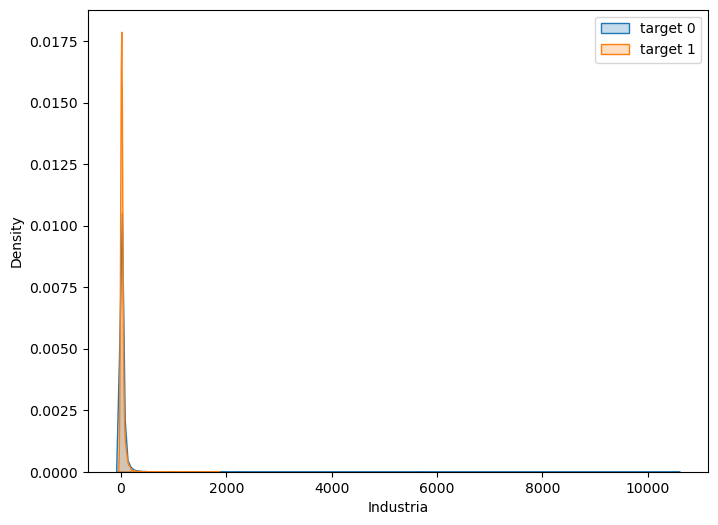

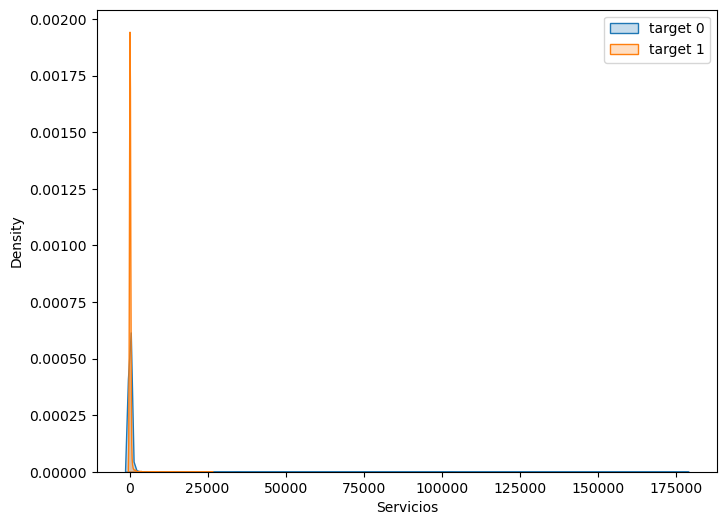

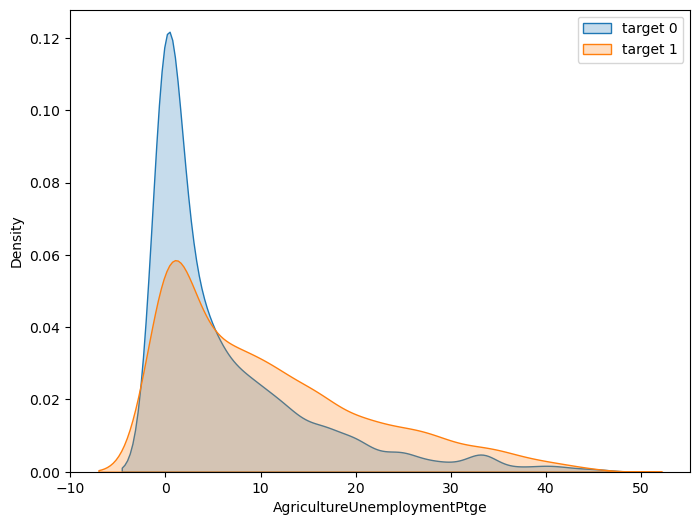

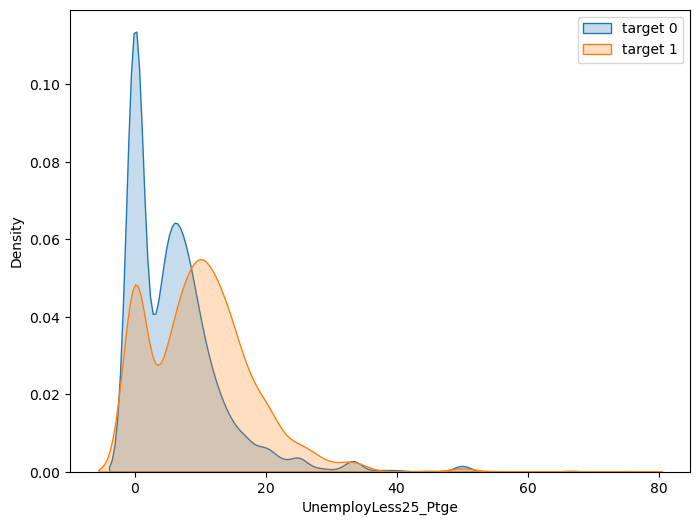

In [28]:
hist_targetbinaria(datos_input['Industria'],varObjIzquierda,'Industria')
hist_targetbinaria(datos_input['Servicios'],varObjIzquierda, 'Servicios')
hist_targetbinaria(datos_input['AgricultureUnemploymentPtge'],varObjIzquierda, 'AgricultureUnemploymentPtge')
hist_targetbinaria(datos_input['UnemployLess25_Ptge'],varObjIzquierda, 'UnemployLess25_Ptge')

<h4>Izda_Pct</h4>

In [29]:
resultados_Izda_Pct = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzdaPct)
    resultados_Izda_Pct.append((v,coeficiente_cramer))

resultados_Izda_Pct.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda_Pct")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_Izda_Pct:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")

Izquierda_Pct

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.20280511033968582
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.14351727942196849
AbstentionPtge: Coeficiente V de Cramer = 0.14078541697030386
SameComAutonDiffProvPtge: Coeficiente V de Cramer = 0.12524371570195286
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.12380657156559965
ActividadPpal: Coeficiente V de Cramer = 0.12001904706334858
SUPERFICIE: Coeficiente V de Cramer = 0.11776528819267092
IndustryUnemploymentPtge: Coeficiente V de Cramer = 0.11307356746568364
Age_0-4_Ptge: Coeficiente V de Cramer = 0.11072998895892325
Age_under19_Ptge: Coeficiente V de Cramer = 0.1100519036220996
Age_over65_pct: Coeficiente V de Cramer = 0.1087078177981892
Explotaciones: Coeficiente V de Cramer = 0.1051898771090461
inmuebles: Coeficiente V de Cramer = 0.10421221246400501
PersonasInmueble: Coeficiente V de Cramer = 0.10099391024921908
Pob201

<ul>
    <li>Menos significativas: Age_0-4_Ptge  y PersonasInmueble</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y SUPERFICIE</li>
</ul>

<h3>Relaciones entre variables predictoras continuas </h3>

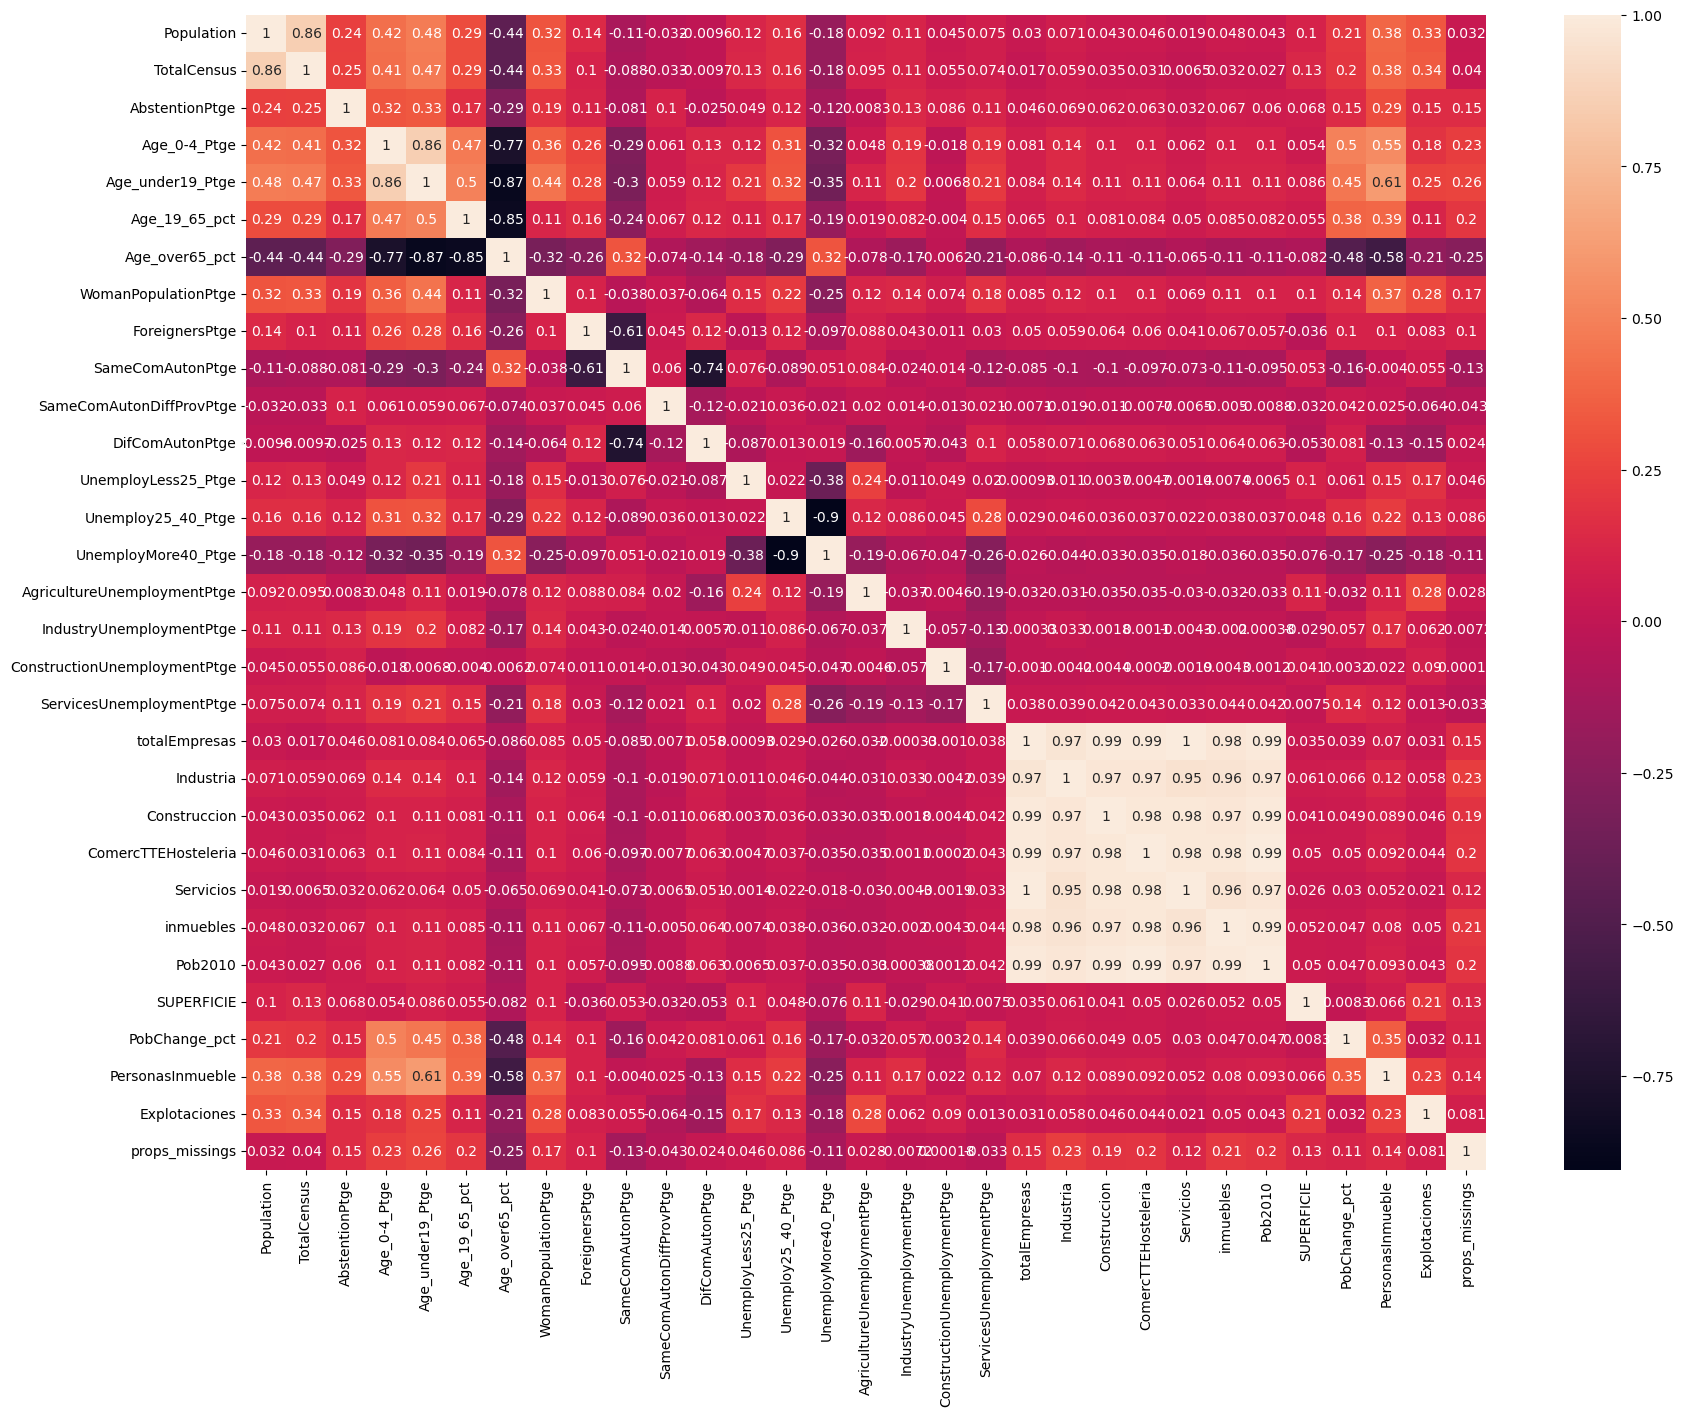

In [30]:
datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Como se puede observar existe una fuertisima correlacion en el siguiente grupo de variables: totalEmpresas, Industria, Construccion, ComercTTEHoteleria, Servicios, inmuebles y pob2010. Al estar tan correladas la informacion que aporten para explicar la variable objetivo probablemente sea redundante entre ellas.

Analizando un poco la relacion que existe entre estas variables y las dos variables objetivos nos damos cuenta que no tienen especial relacion, de hecho (en su mayoria) estan entre las que menos relacion tienen. Debido a esto decidi que voy a remover del conjunto de datos todas menos una de las variables, dejando solo la que mejor desempeño tiene en cuanto a la relacion que presenta con las variables objetivo: "inmuebles"

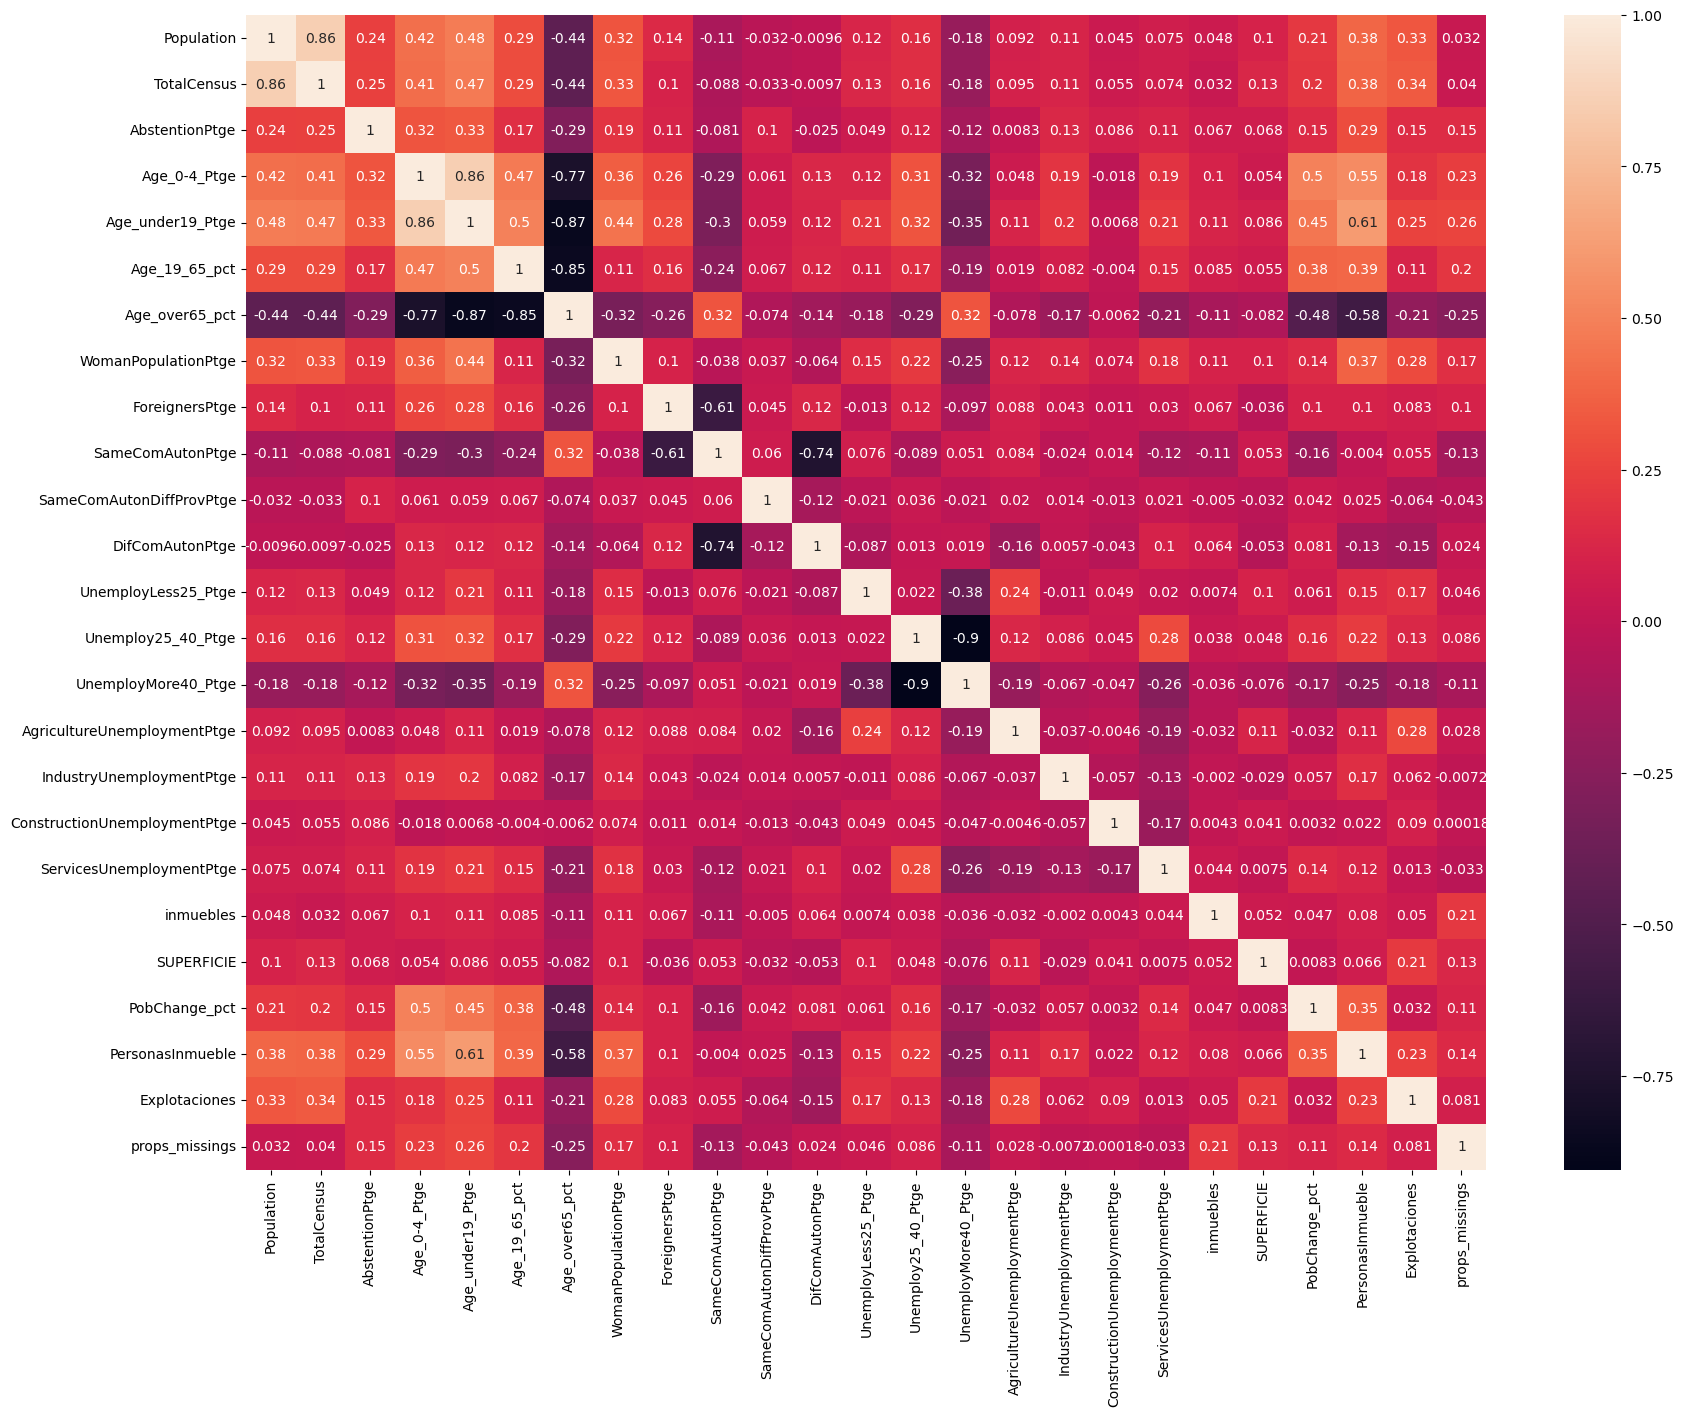

In [31]:
datos_input = datos_input.drop(['ComercTTEHosteleria', 'Industria', 'Servicios', 'Construccion', 'totalEmpresas', 'Pob2010'], axis=1)

datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

<h2> 8 - Elaboracion del modelo de Regresion Lineal</h2>

<h3>Muestras de entrenamiento y Test<h3>

Realizamos las particiones del conjunto de datos para entrenamiento del modelo y test, vamos a tener en cuenta todas las variables que han pasado por nuestra depuracion. Las particiones de datos para entrenamiento y prueba se hacen de manera independiente para cada variable objetivo.

In [32]:
izquierda_predictoras_train, izquierda_predictoras_test,izquierda_objetivo_train, izquierda_objetivo_test=train_test_split(
    datos_input, varObjIzquierda, test_size=0.2, random_state=123456)

izq_pct_predictoras_train, izq_pct_predictoras_test, izq_pct_objetivo_train, izq_pct_objetivo_test=train_test_split(
    datos_input, varObjIzdaPct, test_size=0.2, random_state=123456)


variables_predictoras_continuas = ['Population', 'TotalCensus', 'AbstentionPtge', 'Age_0-4_Ptge',
       'Age_under19_Ptge', 'Age_19_65_pct', 'Age_over65_pct',
       'WomanPopulationPtge', 'ForeignersPtge', 'SameComAutonPtge',
       'SameComAutonDiffProvPtge', 'DifComAutonPtge', 'UnemployLess25_Ptge',
       'Unemploy25_40_Ptge', 'UnemployMore40_Ptge',
       'AgricultureUnemploymentPtge', 'IndustryUnemploymentPtge',
       'ConstructionUnemploymentPtge', 'ServicesUnemploymentPtge',
       'inmuebles', 'SUPERFICIE', 'PobChange_pct',
       'PersonasInmueble', 'Explotaciones']

variables_predictoras_categoricas = ['Densidad', 'ActividadPpal']


<h3>Modelos a partir de metodos clasicos de seleccion de variables</h3>

<h4>Variable Objetivo Izquierda</h4>

<h5>Método Backward</h5>

In [33]:
rl_izquierda_backward_aic = lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izquierda_backward_aic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_backward_aic['Variables']['cont'], 
                                                rl_izquierda_backward_aic['Variables']['categ'], 
                                                rl_izquierda_backward_aic['Variables']['inter'])

Start: AIC = 7081.927499268448

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6833.411099
  + AgricultureUnemploymentPtge 6867.603479
                + ActividadPpal 6892.504112
                + Explotaciones 6947.468000
                   + SUPERFICIE 6951.344912
          + UnemployMore40_Ptge 6995.367639
               + Age_over65_pct 7013.880529
     + SameComAutonDiffProvPtge 7020.251543
                + Age_19_65_pct 7021.347246
                  + TotalCensus 7029.561004
                   + Population 7032.701614
             + Age_under19_Ptge 7036.210563
               + ForeignersPtge 7045.504567
          + WomanPopulationPtge 7046.620866
             + PersonasInmueble 7051.772830
     + IndustryUnemploymentPtge 7054.198869
 + ConstructionUnemploymentPtge 7064.720121
           + Unemploy25_40_Ptge 7065.712415
             + SameComAutonPtge 7076.079551
               + AbstentionPtge 7077.107001
                 + Age_0-4_Ptge 7078.

In [34]:
rl_izquierda_backward_bic = lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izquierda_backward_bic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_backward_bic['Variables']['cont'], 
                                                rl_izquierda_backward_bic['Variables']['categ'], 
                                                rl_izquierda_backward_bic['Variables']['inter'])

Start: BIC = 7088.705979220957

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6846.968059
  + AgricultureUnemploymentPtge 6881.160439
                + ActividadPpal 6926.396512
                + Explotaciones 6961.024960
                   + SUPERFICIE 6964.901872
          + UnemployMore40_Ptge 7008.924599
               + Age_over65_pct 7027.437489
     + SameComAutonDiffProvPtge 7033.808503
                + Age_19_65_pct 7034.904206
                  + TotalCensus 7043.117964
                   + Population 7046.258574
             + Age_under19_Ptge 7049.767523
               + ForeignersPtge 7059.061527
          + WomanPopulationPtge 7060.177826
             + PersonasInmueble 7065.329790
     + IndustryUnemploymentPtge 7067.755829
 + ConstructionUnemploymentPtge 7078.277080
           + Unemploy25_40_Ptge 7079.269375
             + SameComAutonPtge 7089.636511
               + AbstentionPtge 7090.663961
                 + Age_0-4_Ptge 7091.

<h5>Metodo Forward</h5>

In [35]:
rl_izquierda_forward_aic =  lm_forward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izquierda_forward_aic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_forward_aic['Variables']['cont'], 
                                                rl_izquierda_forward_aic['Variables']['categ'], 
                                                rl_izquierda_forward_aic['Variables']['inter'])

Start: AIC = 7081.927499268448

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6833.411099
  + AgricultureUnemploymentPtge 6867.603479
                + ActividadPpal 6892.504112
                + Explotaciones 6947.468000
                   + SUPERFICIE 6951.344912
          + UnemployMore40_Ptge 6995.367639
               + Age_over65_pct 7013.880529
     + SameComAutonDiffProvPtge 7020.251543
                + Age_19_65_pct 7021.347246
                  + TotalCensus 7029.561004
                   + Population 7032.701614
             + Age_under19_Ptge 7036.210563
               + ForeignersPtge 7045.504567
          + WomanPopulationPtge 7046.620866
             + PersonasInmueble 7051.772830
     + IndustryUnemploymentPtge 7054.198869
 + ConstructionUnemploymentPtge 7064.720121
           + Unemploy25_40_Ptge 7065.712415
             + SameComAutonPtge 7076.079551
               + AbstentionPtge 7077.107001
                 + Age_0-4_Ptge 7078.

In [36]:
rl_izquierda_forward_bic =  lm_forward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izquierda_forward_bic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_forward_bic['Variables']['cont'], 
                                                rl_izquierda_forward_bic['Variables']['categ'], 
                                                rl_izquierda_forward_bic['Variables']['inter'])

Start: BIC = 7088.705979220957

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6846.968059
  + AgricultureUnemploymentPtge 6881.160439
                + ActividadPpal 6926.396512
                + Explotaciones 6961.024960
                   + SUPERFICIE 6964.901872
          + UnemployMore40_Ptge 7008.924599
               + Age_over65_pct 7027.437489
     + SameComAutonDiffProvPtge 7033.808503
                + Age_19_65_pct 7034.904206
                  + TotalCensus 7043.117964
                   + Population 7046.258574
             + Age_under19_Ptge 7049.767523
               + ForeignersPtge 7059.061527
          + WomanPopulationPtge 7060.177826
             + PersonasInmueble 7065.329790
     + IndustryUnemploymentPtge 7067.755829
 + ConstructionUnemploymentPtge 7078.277080
           + Unemploy25_40_Ptge 7079.269375
             + SameComAutonPtge 7089.636511
               + AbstentionPtge 7090.663961
                 + Age_0-4_Ptge 7091.

<h5>Metodo Stepwise</h5>

In [37]:
rl_izquierda_stepwise_aic =  lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izquierda_stepwise_aic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_stepwise_aic['Variables']['cont'], 
                                                rl_izquierda_stepwise_aic['Variables']['categ'], 
                                                rl_izquierda_stepwise_aic['Variables']['inter'])

Start: AIC = 7081.927499268448

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6833.411099
  + AgricultureUnemploymentPtge 6867.603479
                + ActividadPpal 6892.504112
                + Explotaciones 6947.468000
                   + SUPERFICIE 6951.344912
          + UnemployMore40_Ptge 6995.367639
               + Age_over65_pct 7013.880529
     + SameComAutonDiffProvPtge 7020.251543
                + Age_19_65_pct 7021.347246
                  + TotalCensus 7029.561004
                   + Population 7032.701614
             + Age_under19_Ptge 7036.210563
               + ForeignersPtge 7045.504567
          + WomanPopulationPtge 7046.620866
             + PersonasInmueble 7051.772830
     + IndustryUnemploymentPtge 7054.198869
 + ConstructionUnemploymentPtge 7064.720121
           + Unemploy25_40_Ptge 7065.712415
             + SameComAutonPtge 7076.079551
               + AbstentionPtge 7077.107001
                 + Age_0-4_Ptge 7078.

In [38]:
rl_izquierda_stepwise_bic =  lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izquierda_stepwise_bic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_stepwise_bic['Variables']['cont'], 
                                                rl_izquierda_stepwise_bic['Variables']['categ'], 
                                                rl_izquierda_stepwise_bic['Variables']['inter'])

Start: BIC = 7088.705979220957

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6846.968059
  + AgricultureUnemploymentPtge 6881.160439
                + ActividadPpal 6926.396512
                + Explotaciones 6961.024960
                   + SUPERFICIE 6964.901872
          + UnemployMore40_Ptge 7008.924599
               + Age_over65_pct 7027.437489
     + SameComAutonDiffProvPtge 7033.808503
                + Age_19_65_pct 7034.904206
                  + TotalCensus 7043.117964
                   + Population 7046.258574
             + Age_under19_Ptge 7049.767523
               + ForeignersPtge 7059.061527
          + WomanPopulationPtge 7060.177826
             + PersonasInmueble 7065.329790
     + IndustryUnemploymentPtge 7067.755829
 + ConstructionUnemploymentPtge 7078.277080
           + Unemploy25_40_Ptge 7079.269375
             + SameComAutonPtge 7089.636511
               + AbstentionPtge 7090.663961
                 + Age_0-4_Ptge 7091.

<h4>Variable Objetivo Izq_Pct</h4>

<h5>Metodo Backward</h5>

In [39]:
rl_izq_pct_backward_aic =  lm_backward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izq_pct_backward_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_backward_aic['Variables']['cont'], 
                                                rl_izq_pct_backward_aic['Variables']['categ'], 
                                                rl_izq_pct_backward_aic['Variables']['inter'])

Start: AIC = 52994.46468691925

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable          AIC
     - SameComAutonDiffProvPtge 53239.335107
  - AgricultureUnemploymentPtge 53120.527797
                - ActividadPpal 53100.495701
                   - SUPERFICIE 53083.979999
     - IndustryUnemploymentPtge 53076.082148
               - AbstentionPtge 53073.951544
          - UnemployLess25_Ptge 53069.448431
              - DifComAutonPtge 53055.620303
 - ConstructionUnemploymentPtge 53028.234982
                 -

In [40]:
rl_izq_pct_backward_bic =  lm_backward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izq_pct_backward_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_backward_bic['Variables']['cont'], 
                                                rl_izq_pct_backward_bic['Variables']['categ'], 
                                                rl_izq_pct_backward_bic['Variables']['inter'])

Start: BIC = 53204.59756544702

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable          BIC
     - SameComAutonDiffProvPtge 53442.689506
  - AgricultureUnemploymentPtge 53323.882195
                   - SUPERFICIE 53287.334397
                - ActividadPpal 53283.514659
     - IndustryUnemploymentPtge 53279.436546
               - AbstentionPtge 53277.305942
          - UnemployLess25_Ptge 53272.802829
              - DifComAutonPtge 53258.974701
 - ConstructionUnemploymentPtge 53231.589381
                 -

<h5>Metodo Forward</h5>

In [41]:
rl_izq_pct_forward_aic =  lm_forward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izq_pct_forward_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_forward_aic['Variables']['cont'], 
                                                rl_izq_pct_forward_aic['Variables']['categ'], 
                                                rl_izq_pct_forward_aic['Variables']['inter'])

Start: AIC = 54871.51659400477

y ~ 1

                       Variable          AIC
          + UnemployLess25_Ptge 54476.733662
     + SameComAutonDiffProvPtge 54519.984020
  + AgricultureUnemploymentPtge 54574.635428
                + ActividadPpal 54596.234522
                   + SUPERFICIE 54634.214716
                + Explotaciones 54674.918247
          + UnemployMore40_Ptge 54724.380715
     + IndustryUnemploymentPtge 54767.482311
              + DifComAutonPtge 54781.387624
               + AbstentionPtge 54787.395870
               + ForeignersPtge 54819.405947
 + ConstructionUnemploymentPtge 54821.865002
                  + TotalCensus 54827.890307
                + Age_19_65_pct 54832.636467
                   + Population 54834.921400
           + Unemploy25_40_Ptge 54838.663066
                     + Densidad 54840.200894
          + WomanPopulationPtge 54850.693168
               + Age_over65_pct 54850.962511
                 + Age_0-4_Ptge 54865.636546
             + S

In [42]:
rl_izq_pct_forward_bic =  lm_forward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izq_pct_forward_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_forward_bic['Variables']['cont'], 
                                                rl_izq_pct_forward_bic['Variables']['categ'], 
                                                rl_izq_pct_forward_bic['Variables']['inter'])

Start: BIC = 54878.29507395728

y ~ 1

                       Variable          BIC
          + UnemployLess25_Ptge 54490.290622
     + SameComAutonDiffProvPtge 54533.540980
  + AgricultureUnemploymentPtge 54588.192388
                + ActividadPpal 54630.126922
                   + SUPERFICIE 54647.771676
                + Explotaciones 54688.475207
          + UnemployMore40_Ptge 54737.937675
     + IndustryUnemploymentPtge 54781.039271
              + DifComAutonPtge 54794.944584
               + AbstentionPtge 54800.952830
               + ForeignersPtge 54832.962907
 + ConstructionUnemploymentPtge 54835.421961
                  + TotalCensus 54841.447267
                + Age_19_65_pct 54846.193426
                   + Population 54848.478360
           + Unemploy25_40_Ptge 54852.220026
                     + Densidad 54860.536334
          + WomanPopulationPtge 54864.250128
               + Age_over65_pct 54864.519471
                 + Age_0-4_Ptge 54879.193506
             + S

<h5>Método Stepwise</h5>

In [43]:
rl_izq_pct_stepwise_aic =  lm_stepwise(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas,[],'AIC')

data_rl_izq_pct_stepwise_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_stepwise_aic['Variables']['cont'], 
                                                rl_izq_pct_stepwise_aic['Variables']['categ'], 
                                                rl_izq_pct_stepwise_aic['Variables']['inter'])

Start: AIC = 54871.51659400477

y ~ 1

                       Variable          AIC
          + UnemployLess25_Ptge 54476.733662
     + SameComAutonDiffProvPtge 54519.984020
  + AgricultureUnemploymentPtge 54574.635428
                + ActividadPpal 54596.234522
                   + SUPERFICIE 54634.214716
                + Explotaciones 54674.918247
          + UnemployMore40_Ptge 54724.380715
     + IndustryUnemploymentPtge 54767.482311
              + DifComAutonPtge 54781.387624
               + AbstentionPtge 54787.395870
               + ForeignersPtge 54819.405947
 + ConstructionUnemploymentPtge 54821.865002
                  + TotalCensus 54827.890307
                + Age_19_65_pct 54832.636467
                   + Population 54834.921400
           + Unemploy25_40_Ptge 54838.663066
                     + Densidad 54840.200894
          + WomanPopulationPtge 54850.693168
               + Age_over65_pct 54850.962511
                 + Age_0-4_Ptge 54865.636546
             + S

In [44]:
rl_izq_pct_stepwise_bic =  lm_stepwise(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas,[],'BIC')

data_rl_izq_pct_stepwise_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_stepwise_bic['Variables']['cont'], 
                                                rl_izq_pct_stepwise_bic['Variables']['categ'], 
                                                rl_izq_pct_stepwise_bic['Variables']['inter'])

Start: BIC = 54878.29507395728

y ~ 1

                       Variable          BIC
          + UnemployLess25_Ptge 54490.290622
     + SameComAutonDiffProvPtge 54533.540980
  + AgricultureUnemploymentPtge 54588.192388
                + ActividadPpal 54630.126922
                   + SUPERFICIE 54647.771676
                + Explotaciones 54688.475207
          + UnemployMore40_Ptge 54737.937675
     + IndustryUnemploymentPtge 54781.039271
              + DifComAutonPtge 54794.944584
               + AbstentionPtge 54800.952830
               + ForeignersPtge 54832.962907
 + ConstructionUnemploymentPtge 54835.421961
                  + TotalCensus 54841.447267
                + Age_19_65_pct 54846.193426
                   + Population 54848.478360
           + Unemploy25_40_Ptge 54852.220026
                     + Densidad 54860.536334
          + WomanPopulationPtge 54864.250128
               + Age_over65_pct 54864.519471
                 + Age_0-4_Ptge 54879.193506
             + S

<h5>Comparativa de los metodos clasicos de seleccion de variables</h5>

<h5>Izq_Pct</h5>

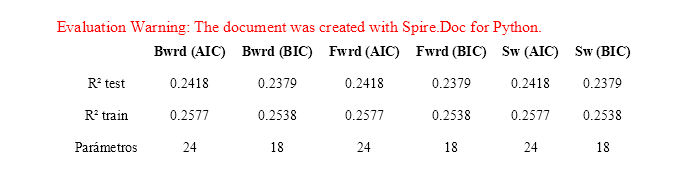

In [45]:
comparative_table_html_izq_pct = f"""
<!DOCTYPE html>
<html>
<head>
<style>
/* Aquí va tu CSS */
table {{
  table-layout: fixed;
  with: auto;
  border-collapse: collapse;
  margin: 10px;
}}

td, th {{
  height: auto;
  padding: 8px;
  font-size: 14px;
  text-align: center;
}}
</style>
</head>
<body>
<table>
  <thead>
    <tr>
      <th></th>
      <th>Bwrd (AIC)</th>
      <th>Bwrd (BIC)</th>
      <th>Fwrd (AIC)</th>
      <th>Fwrd (BIC)</th>
      <th>Sw (AIC)</th>
      <th>Sw (BIC)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>R² test</td>
      <td>{Rsq(rl_izq_pct_backward_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_backward_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_backward_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_backward_bic):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_forward_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_forward_bic):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_stepwise_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_stepwise_bic):.4f}</td>
    </tr>
    <tr>
      <td>R² train</td>
      <td>{Rsq(rl_izq_pct_backward_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_backward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_backward_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_backward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_forward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_forward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_stepwise_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_stepwise_bic['X']):.4f}</td>
    </tr>
    <tr>
      <td>Parámetros</td>
      <td>{len(rl_izq_pct_backward_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_backward_bic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_forward_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_forward_bic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_stepwise_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_stepwise_bic['Modelo'].params)}</td>
    </tr>
  </tbody>
</table>
"""

document = Document()
sec = document.AddSection()
paragraph = sec.AddParagraph()
paragraph.AppendHTML(comparative_table_html_izq_pct)

imageStream = document.SaveImageToStreams(0, ImageType.Bitmap)

with open("./comparative_table_img_izq_pct.png",'wb') as imageFile:
    imageFile.write(imageStream.ToArray())
document.Close()

try:
  img = PILImage.open("./comparative_table_img_izq_pct.png")
  bbox = (10,10,700,200) 
  cropped_img = img.crop(bbox)
  cropped_img.save("./comparative_table_img_izq_pct.png") 
  display(Image(filename='./comparative_table_img_izq_pct.png'))
except:
  display(Image(filename='./comparative_table_img_izq_pct.png'))


<h5>Izquierda</h5>

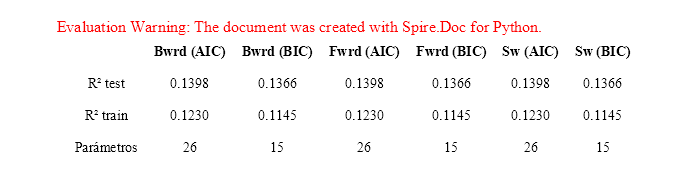

In [46]:
comparative_table_html_izquierda = f"""
<!DOCTYPE html>
<html>
<head>
<style>
/* Aquí va tu CSS */
table {{
  table-layout: fixed;
  with: auto;
  border-collapse: collapse;
  margin: 10px;
}}

td, th {{
  height: auto;
  padding: 8px;
  font-size: 14px;
  text-align: center;
}}
</style>
</head>
<body>
<table>
  <thead>
    <tr>
      <th></th>
      <th>Bwrd (AIC)</th>
      <th>Bwrd (BIC)</th>
      <th>Fwrd (AIC)</th>
      <th>Fwrd (BIC)</th>
      <th>Sw (AIC)</th>
      <th>Sw (BIC)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>R² test</td>
      <td>{Rsq(rl_izquierda_backward_aic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_backward_aic):.4f}</td>
      <td>{Rsq(rl_izquierda_backward_bic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_backward_bic):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_aic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_forward_aic):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_bic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_forward_bic):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_aic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_stepwise_aic):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_bic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_stepwise_bic):.4f}</td>
    </tr>
    <tr>
      <td>R² train</td>
      <td>{Rsq(rl_izquierda_backward_aic['Modelo'],izquierda_objetivo_train,rl_izquierda_backward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_backward_bic['Modelo'],izquierda_objetivo_train,rl_izquierda_backward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_aic['Modelo'],izquierda_objetivo_train,rl_izquierda_forward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_bic['Modelo'],izquierda_objetivo_train,rl_izquierda_forward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_aic['Modelo'],izquierda_objetivo_train,rl_izquierda_stepwise_aic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_bic['Modelo'],izquierda_objetivo_train,rl_izquierda_stepwise_bic['X']):.4f}</td>
    </tr>
    <tr>
      <td>Parámetros</td>
      <td>{len(rl_izquierda_backward_aic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_backward_bic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_forward_aic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_forward_bic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_stepwise_aic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_stepwise_bic['Modelo'].params)}</td>
    </tr>
  </tbody>
</table>
"""

document = Document()
sec = document.AddSection()
paragraph = sec.AddParagraph()
paragraph.AppendHTML(comparative_table_html_izquierda)

imageStream = document.SaveImageToStreams(0, ImageType.Bitmap)

with open("./comparative_table_img_izquierda.png",'wb') as imageFile:
    imageFile.write(imageStream.ToArray())
document.Close()

try:
  img = PILImage.open("./comparative_table_img_izquierda.png")
  bbox = (10,10,700,200) 
  cropped_img = img.crop(bbox)
  cropped_img.save("./comparative_table_img_izquierda.png") 
  display(Image(filename='./comparative_table_img_izquierda.png'))
except:
  display(Image(filename='./comparative_table_img_izquierda.png'))

<h3>Modelos a partir de metodos aleatorios de seleccion de variables</h3>

<h4>Izquierda</h4>

Los metodos stepwise, forward y backward son iguales en sus respectivas variantes AIC y BIC y presentan una variabilidad reducida para los conjuntos de datos de test y train, estas variantes estan diferenciadas por un R² ligeramente superior para el metodo AIC pero un numero de parametros bastante superior. 

Para utilizar el metodo aleatorio de seleccion de variable seleccionamos el metodo stepwise en su variante BIC por el numero mas reducido de parametros que lo hace mas util a futuro asi como menos factible de presentar sesgo.

In [69]:
variables_seleccionadas = {
    'Formula': [],
    'Variables': []
}

for x in range(30):
    print('---------------------------- iter: ' + str(x))
    
    x_train2, x_test2, y_train2, y_test2 = train_test_split(izquierda_predictoras_train, izquierda_objetivo_train, 
                                                            test_size = 0.3, random_state = 1234567 + x)

    modelo = lm_stepwise(y_train2.astype(int), x_train2, variables_predictoras_continuas, variables_predictoras_categoricas, [], 'BIC')

    variables_seleccionadas['Variables'].append(modelo['Variables'])
    variables_seleccionadas['Formula'].append(sorted(modelo['Modelo'].model.exog_names))

variables_seleccionadas['Formula'] = list(map(lambda x: '+'.join(x), variables_seleccionadas['Formula']))

frecuencias = Counter(variables_seleccionadas['Formula'])
frec_ordenada = pd.DataFrame(list(frecuencias.items()), columns = ['Formula', 'Frecuencia'])
frec_ordenada = frec_ordenada.sort_values('Frecuencia', ascending = False).reset_index()

var_1 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][0])]
var_2 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][1])]


---------------------------- iter: 0
Start: BIC = 5013.374032762509

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 4840.225176
  + AgricultureUnemploymentPtge 4869.924112
                + ActividadPpal 4923.509517
                + Explotaciones 4928.758842
                   + SUPERFICIE 4932.695843
          + UnemployMore40_Ptge 4959.826226
               + Age_over65_pct 4977.373984
     + SameComAutonDiffProvPtge 4980.842554
                  + TotalCensus 4982.192789
                + Age_19_65_pct 4983.243048
                   + Population 4991.120017
             + Age_under19_Ptge 4994.428991
               + ForeignersPtge 4994.818242
     + IndustryUnemploymentPtge 4998.403211
          + WomanPopulationPtge 5001.133360
             + PersonasInmueble 5003.324361
 + ConstructionUnemploymentPtge 5007.671775
           + Unemploy25_40_Ptge 5010.988263
             + SameComAutonPtge 5015.830184
               + AbstentionPtge 5017.732277


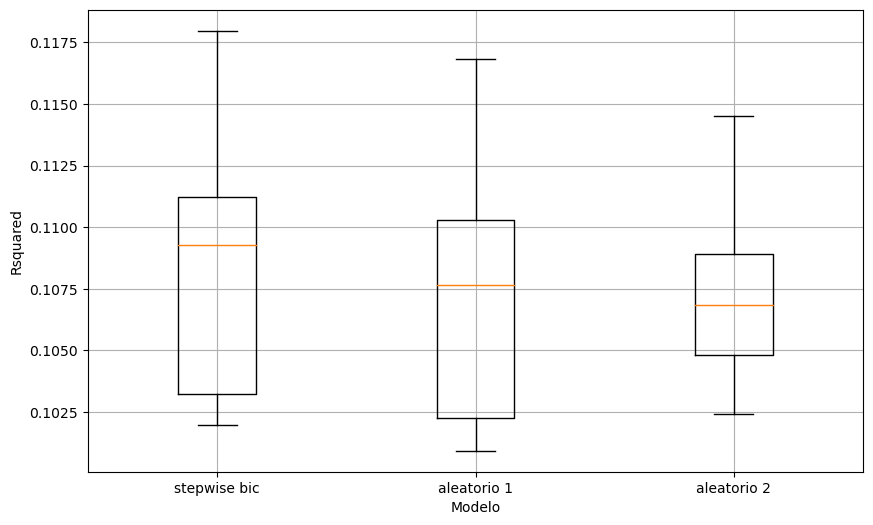

In [70]:
results = pd.DataFrame({
    'Rsquared': []
    , 'Resample': []
    , 'Modelo': []
})
for rep in range(20):
    modelo1 = validacion_cruzada_lm(
        5
        , izquierda_predictoras_train
        , izquierda_objetivo_train
        , rl_izquierda_stepwise_bic['Variables']['cont']
        , rl_izquierda_stepwise_bic['Variables']['categ']
        , rl_izquierda_stepwise_bic['Variables']['inter']
    )
    modelo2 = validacion_cruzada_lm(
        5
        , izquierda_predictoras_train
        , izquierda_objetivo_train
        , var_1['cont']
        , var_1['categ']
        , var_1['inter']
    )
    modelo3 = validacion_cruzada_lm(
        5
        , izquierda_predictoras_train
        , izquierda_objetivo_train
        , var_2['cont']
        , var_2['categ']
        , var_2['inter']
    )
    
    results_rep = pd.DataFrame({
        'Rsquared': modelo1 + modelo2 + modelo3 
        , 'Resample': ['Rep' + str((rep + 1))]*5*3
        , 'Modelo': [1]*5 + [2]*5 + [3]*5 
    })
    results = pd.concat([results, results_rep], axis = 0)


plt.figure(figsize=(10, 6)) 
plt.grid(True)  

grupo_metrica = results.groupby('Modelo')['Rsquared']
boxplot_data = [grupo_metrica.get_group(grupo).tolist() for grupo in grupo_metrica.groups]

model_labels = ["stepwise bic", "aleatorio 1", "aleatorio 2"]
plt.boxplot(boxplot_data, labels=model_labels)

plt.xlabel('Modelo')  
plt.ylabel('Rsquared')  
plt.show() 


In [71]:
print("Numero de parametros para stepwise bic: "+ str(len(rl_izquierda_stepwise_bic['Modelo'].params)))
print("Numero de parametros para modelo con seleccionde varaibles aleatorias 1: " + str(len(var_1['cont'])+len(var_1['categ'])))
print("Numero de parametros para con selccion de variables aleatorio 2: "+ str(len(var_2['cont'])+len(var_2['categ'])))

Numero de parametros para stepwise bic: 15
Numero de parametros para modelo con seleccionde varaibles aleatorias 1: 10
Numero de parametros para con selccion de variables aleatorio 2: 10


<h4>Izda_Pct</h4>

Los metodos backward, forward y stepwise son identicos en sus respectivas variantes AIC y BIC y la variabilidad del R² que presentan entre el conjunto de test y train es reducida. Lo que los diferencia es un R² algo superior en las variantes de BIC asi como unos cuantos parametros mas. 

La seleccion no es sencilla porque la diferencia del R² no es tan reducida como para considerarla despreciable asi como el numero de paraemtros es tambien una diferencia considerable, me voy a decantar por tener un menor numero de parametros porque el R² no es muy bajo en ambos modelos, el modelo explica muy mal la variable objetivo para ambos modelos por lo que aunque la diferencia no sea del todo despreciable el R² es tan bajo que no creo que tenga demsiado peso el argumento de la diferencia que hay en la capacidad explicativa de los modelos. Con estas consideraciones elejimos el modelo que utilizo el metodo de seleccion de variables Stepwise con el criterio BIC

In [73]:
variables_seleccionadas = {
    'Formula': [],
    'Variables': []
}

for x in range(30):
    print('---------------------------- iter: ' + str(x))
    
    x_train2, x_test2, y_train2, y_test2 = train_test_split(izq_pct_predictoras_train, izquierda_objetivo_train, 
                                                            test_size = 0.3, random_state = 1234567 + x)
    
    modelo = lm_stepwise(y_train2.astype(int), x_train2, variables_predictoras_continuas, variables_predictoras_categoricas, [], 'BIC')
    
    variables_seleccionadas['Variables'].append(modelo['Variables'])
    variables_seleccionadas['Formula'].append(sorted(modelo['Modelo'].model.exog_names))

variables_seleccionadas['Formula'] = list(map(lambda x: '+'.join(x), variables_seleccionadas['Formula']))

frecuencias = Counter(variables_seleccionadas['Formula'])
frec_ordenada = pd.DataFrame(list(frecuencias.items()), columns = ['Formula', 'Frecuencia'])
frec_ordenada = frec_ordenada.sort_values('Frecuencia', ascending = False).reset_index()

var_1 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][0])]
var_2 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][1])]


---------------------------- iter: 0
Start: BIC = 5013.374032762509

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 4840.225176
  + AgricultureUnemploymentPtge 4869.924112
                + ActividadPpal 4923.509517
                + Explotaciones 4928.758842
                   + SUPERFICIE 4932.695843
          + UnemployMore40_Ptge 4959.826226
               + Age_over65_pct 4977.373984
     + SameComAutonDiffProvPtge 4980.842554
                  + TotalCensus 4982.192789
                + Age_19_65_pct 4983.243048
                   + Population 4991.120017
             + Age_under19_Ptge 4994.428991
               + ForeignersPtge 4994.818242
     + IndustryUnemploymentPtge 4998.403211
          + WomanPopulationPtge 5001.133360
             + PersonasInmueble 5003.324361
 + ConstructionUnemploymentPtge 5007.671775
           + Unemploy25_40_Ptge 5010.988263
             + SameComAutonPtge 5015.830184
               + AbstentionPtge 5017.732277


Comparamos el modelo ganador de la seleccion por los metodos clasicos con los dos nuevos modelos.

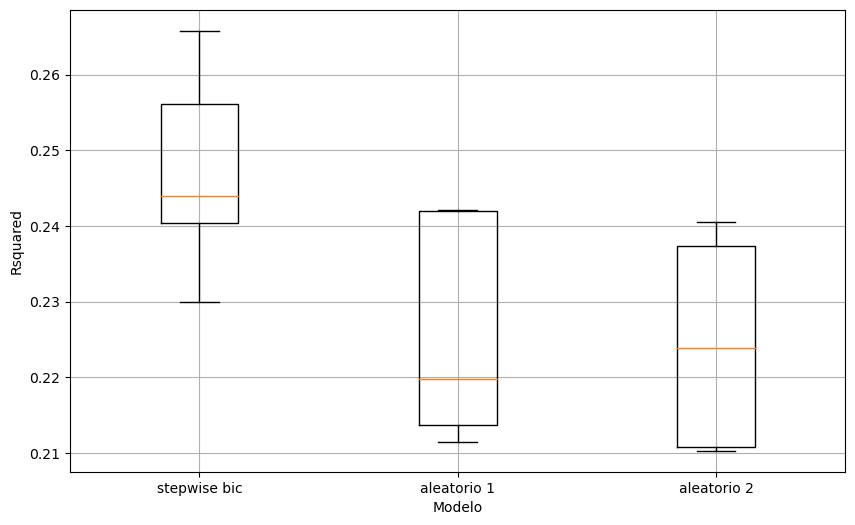

In [76]:
results = pd.DataFrame({
    'Rsquared': []
    , 'Resample': []
    , 'Modelo': []
})
for rep in range(20):
    modelo1 = validacion_cruzada_lm(
        5
        , izq_pct_predictoras_train
        , izq_pct_objetivo_train
        , rl_izq_pct_stepwise_bic['Variables']['cont']
        , rl_izq_pct_stepwise_bic['Variables']['categ']
        , rl_izq_pct_stepwise_bic['Variables']['inter']
    )
    modelo2 = validacion_cruzada_lm(
        5
        , izq_pct_predictoras_train
        , izq_pct_objetivo_train
        , var_1['cont']
        , var_1['categ']
        , var_1['inter']
    )
    modelo3 = validacion_cruzada_lm(
        5
        , izq_pct_predictoras_train
        , izq_pct_objetivo_train
        , var_2['cont']
        , var_2['categ']
        , var_2['inter']
    )
    
    results_rep = pd.DataFrame({
        'Rsquared': modelo1 + modelo2 + modelo3 
        , 'Resample': ['Rep' + str((rep + 1))]*5*3
        , 'Modelo': [1]*5 + [2]*5 + [3]*5 
    })
    results = pd.concat([results, results_rep], axis = 0)


plt.figure(figsize=(10, 6)) 
plt.grid(True)  

grupo_metrica = results.groupby('Modelo')['Rsquared']
boxplot_data = [grupo_metrica.get_group(grupo).tolist() for grupo in grupo_metrica.groups]

model_labels = ["stepwise bic", "aleatorio 1", "aleatorio 2"]
plt.boxplot(boxplot_data, labels=model_labels)

plt.xlabel('Modelo')  
plt.ylabel('Rsquared')  
plt.show() 


In [77]:
print("Numero de parametros para stepwise bic: "+ str(len(rl_izq_pct_stepwise_bic['Modelo'].params)))
print("Numero de parametros para modelo con seleccionde varaibles aleatorias 1: " + str(len(var_1['cont'])+len(var_1['categ'])))
print("Numero de parametros para con selccion de variables aleatorio 2: "+ str(len(var_2['cont'])+len(var_2['categ'])))

Numero de parametros para stepwise bic: 18
Numero de parametros para modelo con seleccionde varaibles aleatorias 1: 10
Numero de parametros para con selccion de variables aleatorio 2: 10


Como podemos visualizar en el diagrama de cajas realizado para los modelos aletorios tienen un R² muy similar, los modelos relizados con los metodo de seleccion aleatoria de varaibles
 presenta un r apenas inferior (0.220 y 0.224 vs 0.243 del obtenido por el metodo de seleccion clasica de variables)

 En lo que difieren bastante es en el numero de parametros, donde las variables son considerablemente menos en los modelos obtenidos por el metodo aleatoria de seleccion de variables.

Sin embargo elegimos como modelo ganador al primero obtenido con el metodo clasico de seleccion de variables debido a que tiene el R² mas alto y el numero de parametros no es tan considerable.

In [78]:
rl_izq_pct_stepwise_bic["Modelo"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Izda_Pct   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     129.5
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:36:19   Log-Likelihood:                -26484.
No. Observations:                6493   AIC:                         5.300e+04
Df Residuals:                    6475   BIC:                         5.313e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           23.9528      1.995     12.005      0.000      20.042      27.864
UnemployLess25_Ptge              0.3730      0.024     15.614      0.000       0.326       0.420
SameComAutonDiffProvPtge        -0.6238      0.040    -15.485      0.000      -0.703      -0.545
AgricultureUnemploymentPtge      0.2577      0.021     12.416      0.000       0.217       0.298
SUPERFICIE                       0.0002   1.99e-05     11.085      0.000       0.000       0.000
DifComAutonPtge                  0.3683      0.023     15.725      0.000       0.322       0.414
IndustryUnemploymentPtge        -0.1645      0.018     -9.305      0.000      -0.199      -0.130
AbstentionPtge                  -0.2377      0.025     -9.326      0.000      -0.288      -0.188
ForeignersPtge                  -0.2235      0.026     -8.538      0.000      -0.275      -0.172
ConstructionUnemploymentPtge     0.1064      0.016      6.603      0.000       0.075       0.138
Age_19_65_pct                    0.2302      0.031      7.382      0.000       0.169       0.291
Age_0-4_Ptge                    -0.7449      0.119     -6.262      0.000      -0.978      -0.512
Unemploy25_40_Ptge               0.0574      0.009      6.161      0.000       0.039       0.076
Explotaciones                    0.0116      0.002      5.034      0.000       0.007       0.016
ActividadPpal_Construccion      -6.0953      4.334     -1.406      0.160     -14.591       2.401
ActividadPpal_Industria          0.9926      4.332      0.229      0.819      -7.500       9.485
ActividadPpal_Otros             -3.5880      0.529     -6.777      0.000      -4.626      -2.550
ActividadPpal_Servicios         -8.1094      0.756    -10.732      0.000      -9.591      -6.628
==============================================================================
Omnibus:                       50.361   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.660
Skew:                           0.206   Prob(JB):                     9.99e-12
Kurtosis:                       2.866   Cond. No.                     2.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Se puede observar que el parametro ActividadPpal_Industria no es significativo para el modelo, lo ideal seria removerlo pero eso llevaria a recrear todos los modelos devuelta y a volver a evaluarlos, por el limitado plazo que tenemos para este trabajo voy a ignorar este paso pero seria lo mas conveniente para analizar a ver si mejorar el modelo sin esta variable. Algo similar pasa con ActividadPpal_Construccion aunque en menor medida